<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [24]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

# Import/Helpers

In [3]:
import os
import findspark
#os.environ['SPARK_HOME'] = '/opt/apache-spark'
os.environ['SPARK_HOME'] = '/usr/local/Cellar/apache-spark/2.2.0/libexec/'
findspark.init()
from pyspark import SQLContext, SparkContext
from pyspark.sql import functions as F
from pyspark.sql.functions import udf
from pyspark.sql.types import *
from pyspark.sql import types as T
from pyspark.mllib.stat import Statistics as S
import json
import numpy as np
from pyspark.sql.functions import udf
from pyspark.sql.types import *
from pyspark_dist_explore import hist
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def correlation(df, col1, col2, method='pearson'):
    rdd1 = df.select(col1).rdd.map(lambda x: x[0])
    rdd2 = df.select(col2).rdd.map(lambda x: x[0])
    return S.corr(rdd1, rdd2, method)

Creation of a Spark contest.

In [4]:
sc = SparkContext()
sqlContext = SQLContext(sc)

# Reviews

We load the data from the json file. The data is a small subset containing only items from the following categories:
"Baby", "Automotive" and "Grocery and Gourmet Food". We will use this dataset on our local machine to qualitatively manipulate the data. 

In [15]:
df_review = sqlContext.read.json("reviews_auto_baby_grocery.json")
num_reviews = df_review.count()

## >= 5 Reviews

We get the count of review of distinct article per reviewer and filter those that have less than 5 review.

In [16]:
df_count = df_review.groupBy("reviewerID").agg(F.countDistinct("asin").alias('count')).filter("`count` >= 5")

We get all reviews of reviewers with more than 5 articles.

In [17]:
df_filtered = review_df.join(review_df_count, on='reviewerID').drop('count')
num_five_reviews = df_filtered.count()
print("We have %.d, i.e. %.3f%% of review who belongs to reviewer with 5 or more reviews"%(num_five_reviews, num_five_reviews/num_reviews))

We have 996378, i.e. 0.278% of review who belongs to reviewer with 5 or more reviews


We compute the average grade for each reviewer.

In [18]:
average_std_score = df_filtered.groupBy("reviewerID").agg(F.avg("overall").alias("mean"), F.stddev("overall").alias("std"))
average_std_score.cache().count()

109193

Here are some statistic concerning the average grade for each reviewer.

The first row contains the total number of reviewer considered.

The second row contains the mean of the reviewers' averages grades (left) and the standard deviation of said mean (right).

The third row contains the mean of the reviewers' standard deviations (left) and the standard deviation of said mean (right).

The fourth row contains the mean of the reviewer's lower grades (left) and the standard deviation of said mean (right).

The fourth row contains the mean of the reviewer's higher grades (left) and the standard deviation of said mean (right).

In [19]:
average_std_score.select("mean", "std").describe().show()

+-------+------------------+------------------+
|summary|              mean|               std|
+-------+------------------+------------------+
|  count|            109193|            109193|
|   mean|4.2834718157516365|0.9022456674075624|
| stddev|0.6049040387948184|0.5699621176391938|
|    min|               1.0|               0.0|
|    max|               5.0|2.1908902300206647|
+-------+------------------+------------------+



We then plot the average grade for each reviewer through histograms, with the grade on the x-axys and the number of reviewers who have such mean ranking on the y-axis.

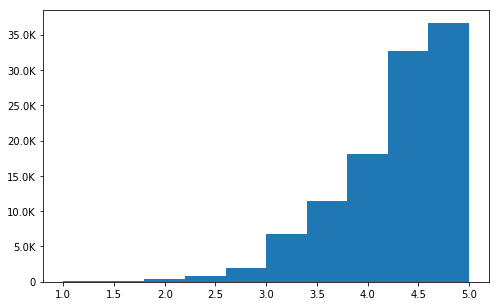

In [21]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
hist(ax, average_std_score.select("mean"));

It can be noted that reviewers tend to give high ratings.

We then plot the average standard deviation for each reviewer through histograms, with the grade on the x-axys and the number of reviewers who have such average standard deviation on the y-axis.

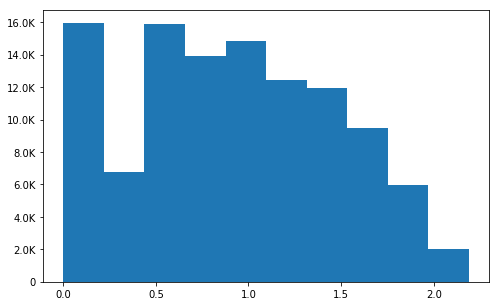

In [22]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
hist(ax, average_std_score.select("std"));

It can be noted that the majority of reviewers tend to have either a very small standard deviation (0-0.25) or a standard deviation between 0.5 and 1.5. The number of people with an higher standard deviation are sensibily less.

Here, we look at the mean of the ratings given by reviewer with small (<0.25) standard deviation.
We also look at what percentage of reviewer they correspond.

There is 14.72% of reviewer with std < 0.25


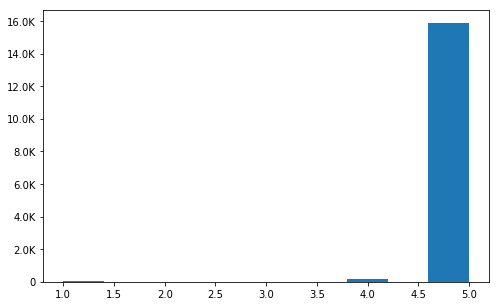

In [23]:
print("There is %.2f%% of reviewer with std < 0.25"%(average_std_score.filter(average_std_score.std < 0.25).count()/average_std_score.count()*100))
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
hist(ax, average_std_score.filter(average_std_score.std < 0.25).select("mean"));

It can be noted that people with a small standard deviation, i.e. people who tend to always give the same rating, tend to give only very high rating (>4.5).

## Word count
Here we count the number of word in a certain review.

In [51]:
wordCount = F.udf(lambda text: len(text.split(" ")), T.IntegerType())

df = df.withColumn('wordcount', wordCount(df["reviewText"]))
df.select("wordcount").describe().show()
overall = df.select("overall").rdd.map(lambda x: x[0])
wordcount = df.select("wordcount").rdd.map(lambda x: x[0])
pearson_corr = correlation(df, "overall", "wordcount", method='pearson')
spearman_corr = correlation(df, "overall", "wordcount", method='spearman')
print("The pearson correlation is %.3f and the spearman is %.3f"%(pearson_corr, spearman_corr))

+-------+-----------------+
|summary|        wordcount|
+-------+-----------------+
|  count|          3586370|
|   mean| 66.7637979349593|
| stddev|72.96104458476789|
|    min|                1|
|    max|             5019|
+-------+-----------------+

The pearson correlation is -0.090 and the spearman is -0.148


The pearson correlation is 0.046 and the spearman is 0.037


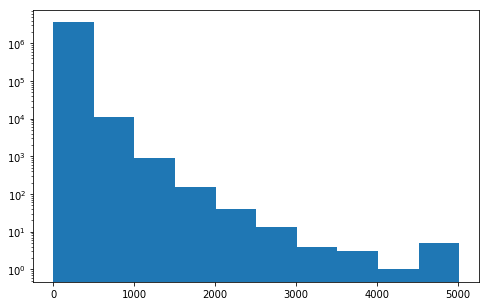

In [52]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
hist(ax, df.select("wordcount"), log=True);
pearson_corr = correlation(df.filter(df.wordcount > 1000), "overall", "wordcount", method='pearson')
spearman_corr = correlation(df.filter(df.wordcount > 1000), "overall", "wordcount", method='spearman')
print("The pearson correlation is %.3f and the spearman is %.3f"%(pearson_corr, spearman_corr))

## Helpfulness
We get the "helpfulness" of a review by computing the ratio of people that found a review helpful and those that voted. If we have no data, we simply put -1 as a ratio.

In [ ]:
df = df.withColumn("helpfulness", F.when(df.helpful.getField(1) > 0, df.helpful.getField(0)/df.helpful.getField(1)).otherwise(-1))

In [ ]:
df.filter(df["helpfulness"] >= 0.0).select("helpfulness").describe().show()

There seems to have some discrepancies amongst the ratio, since the max is at 2.0. We will check that it does not occur too often and may drop the data in the future.

In [ ]:
df.filter(df["helpfulness"] > 1.0).select("helpful").show()

In [ ]:
df.filter((df["helpfulness"] >= 0.0) & (df["helpfulness"] <= 1.0)).corr("overall", "helpfulness")

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
hist(ax, df.filter((df["helpfulness"] >= 0.0) & (df["helpfulness"] <= 1.0)).select("helpfulness"));

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
hist(ax, df.filter((df["helpfulness"] >= 0.0) & (df["helpfulness"] <= 1.0)).select("overall"));

In [ ]:
overall = df.filter((df["helpfulness"] >= 0.0) & (df["helpfulness"] <= 1.0)).select("overall").rdd.map(lambda x: x[0])
helpfulness = df.filter((df["helpfulness"] >= 0.0) & (df["helpfulness"] <= 1.0)).select("helpfulness").rdd.map(lambda x: x[0])
S.corr(overall, helpfulness, method='spearman')

## Brand fidelity/hate

We load the metadata datas and only keep the article number and the brand that are not null, since we are interested in brands.

We then join the dataframe of reviews with the metadata and display some stats.

In [46]:
df_meta = sqlContext.read.json("meta_auto_baby_grocery.json")
df_meta_brand = df_meta.select("asin", "brand").dropna()

df_with_brand = df_filtered.join(df_meta_brand, on='asin')
num_reviews_with_brand = df_with_brand.count()

print("We have %.d, which represents %.3f%% of review with a brand and who belongs to reviewer with 5 or more reviews"%(num_reviews_with_brand, num_reviews_with_brand/num_reviews))
print("We have %.3f%% of review amongst those who belongs to reviewer with 5 or more reviews that have a brand "%(num_reviews_with_brand/num_five_reviews))

We have 599153, which represents 0.167% of review with a brand and who belongs to reviewer with 5 or more reviews
We have 0.601% of review amongst those who belongs to reviewer with 5 or more reviews that have a brand 


We can see that once again we loose a lot of reviews with this approach, but it is still an interesting number to work with.

Then we group by brand and reviewer, compute some stats and filter out all reviewers that have less than 5 reviews for a specific brand.

In [47]:
df_brand_reviewer = df_with_brand.groupBy(["brand", "reviewerID"]).agg(F.count("overall").alias("count"), F.avg("overall").alias("mean"), F.stddev("overall").alias("std")).filter("`count` >= 5")
brand_reviewers_count = df_brand_reviewer.cache().count()
print("We have %.d brand/reviewers tuples"%(brand_reviewers_count))

We have 1602 brand/reviewers tuples


We then show some stats about the mean and std.

+-------+------------------+------------------+------------------+
|summary|             count|              mean|               std|
+-------+------------------+------------------+------------------+
|  count|              1602|              1602|              1602|
|   mean| 6.300249687890138| 4.508185595174844|0.5331499357349924|
| stddev|2.4612651820035443|0.6345228590350631|0.5522432344415494|
|    min|                 5|               1.0|               0.0|
|    max|                36|               5.0|2.1908902300206643|
+-------+------------------+------------------+------------------+



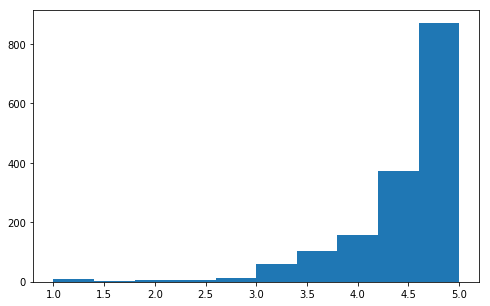

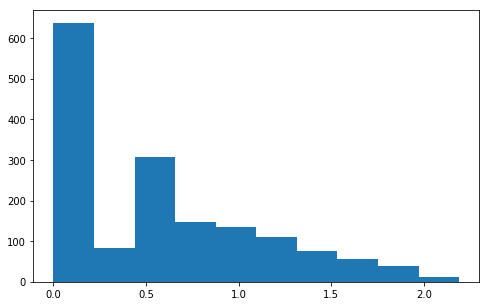

In [49]:
df_brand_reviewer.select("count", "mean", "std").describe().show()
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
hist(ax, df_brand_reviewer.select("mean"));
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
hist(ax, df_brand_reviewer.select("std"));

By comparing qualitatively (we will do a more precise analysis in milestone 3) those graphs with the one from the >= 5 Reviews, we can see that the ratings seems to be having less deviation, showing a tendency to love/hate toward a brand.

We try to see if there is an obvious correlation between number of reviews for a brand and the mean rate:

In [48]:
pearson_corr = correlation(df_brand_reviewer, "count", "mean", method='pearson')
spearman_corr = correlation(df_brand_reviewer, "count", "mean", method='spearman')
print("The pearson correlation is %.3f and the spearman is %.3f"%(pearson_corr, spearman_corr))

The pearson correlation is 0.038 and the spearman is 0.018


At first sight, we cannot see an obvious relationship, however, we will do a more refined analysis in the next milestone.

# Metadata
Here we load the product's metadata.

In [12]:
meta_df = sqlContext.read.json("meta_auto_baby_grocery.json")

Compute the total number of products.

In [13]:
total_products = meta_df.count()
total_products

574167

We filter the salesRank to have only ranked products. There is two possiblity, either the salesRank is completely none, either the categories are all None. we take care of both cases.

In [14]:
def drop_none(salesRank):
    count = 0
    for category, rank in salesRank.asDict().items():
        if rank != None:
            count += 1
    return count == 1
drop_none = udf(drop_none, BooleanType())
filtered_meta_df = meta_df.dropna(subset=['salesRank']).withColumn("toKeep", drop_none("salesRank"))
filtered_meta_df = filtered_meta_df.filter(filtered_meta_df['toKeep'])
filtered_meta_df = filtered_meta_df.drop('toKeep')

Compute the ratio between ranked and total products.

In [15]:
ranked_products = filtered_meta_df.count()
ranked_products
ratio = ranked_products/total_products
print("ranked_products: " + str(ranked_products) + " total products: " + str(total_products) + " ratio: " + str(ratio))

ranked_products: 159803 total products: 574167 ratio: 0.278321463964317


We can notice that in this restricted dataset less than one third of the products is ranked, a fact that makes our rank-based analysis less representative. 

We now check that there is exactly one category that has a sales rank.

In [16]:
def check_exactly_one(salesRank):
    count = 0 
    for category, rank in salesRank.asDict().items():
        if rank != None:
            count += 1
    return count == 1
check_exactly_one = udf(check_exactly_one, BooleanType())
only_one = filtered_meta_df.withColumn("unique_rank", check_exactly_one("salesRank"))
print("There is %.d article with not exactly one category for a rank"%only_one.filter(~only_one["unique_rank"]).count())

There is 0 article with not exactly one category for a rank


Finally, we make the struct flatter, by having a salesRank that has two elements, category and rank.

In [17]:
def notNone(salesRank):
    for category, rank in salesRank.asDict().items():
        if rank != None:
            return (category, rank)
#udf_notNone = udf(notNone, StructType([StructField("category", StringType()), StructField("rank", IntegerType())]))
#filtered_meta_df = filtered_meta_df.withColumn("salesRank", udf_notNone("salesRank"))

Here we obtain the names of the ranking categories.

In [18]:
rank_categories = filtered_meta_df.head().salesRank.asDict().keys()

## Question 4: influence of 'also bought' feature

I'll begin by focus on the 'bought together' feature and not on the 'also bought' feature right away.
This both because the former is more relevant to the question and because it scales better: 'also bought' tends to be a very long list of products while 'bought together' is usually much shorter and easier to analyze.

In order to answer question 4, it is possible to use the following approach:
1. Find the best ranked products for each category.
2. look at the rank of the products that were bought together with them.
3. draw  qualitative conclusions.

First we select the interesting columns of the metadata dataframe, flattening the hierarchical datastructure in the process.

In [19]:
filtered_meta_df = filtered_meta_df.select('salesRank.*', "asin", "related.*")

Then we define a function that allows to find in which category a product has been ranked.

In [20]:
def find_nonnull_category(product):
    for category in rank_categories:
        ranking = product[category]
        if ranking != None:
            return category, ranking 

In [21]:
for category in rank_categories:
    category_df = filtered_meta_df.select(category, "asin", "bought_together").dropna(how='any').sort(category, ascending = False)
    best_products = category_df.take(5)
    for index, best_product in enumerate(best_products):
        productid = best_product.asin
        bought_together = best_product.bought_together
        rank = best_product[category]
        for associated_id in bought_together:
            associated_product = filtered_meta_df.filter(filtered_meta_df.asin == associated_id).first()
            if associated_product != None:
                associated_category, associated_rank = find_nonnull_category(associated_product)
                print("The product " + str(productid) + " ranked " + str(rank) + " in category " + category + " was bought together with the product " + str(associated_id) + " ranked " + str(associated_rank) + " in category " + associated_category)

The product B000BOCATE ranked 344278 in category Home Improvement was bought together with the product B000BOB4VO ranked 202096 in category Kitchen & Dining
The product B005AWYHQG ranked 331032 in category Industrial & Scientific was bought together with the product B005AX2NDE ranked 18295 in category Industrial & Scientific
The product B0083COONQ ranked 244540 in category Industrial & Scientific was bought together with the product B0083COP1M ranked 15092 in category Industrial & Scientific
The product B003L9L43Y ranked 516679 in category Cell Phones & Accessories was bought together with the product B0000GIZTC ranked 175712 in category Grocery & Gourmet Food
The product B000O9IXSI ranked 189377 in category Cell Phones & Accessories was bought together with the product B000LTM29M ranked 452 in category Grocery & Gourmet Food
The product B000O9IXSI ranked 189377 in category Cell Phones & Accessories was bought together with the product B000LTIDR2 ranked 449 in category Grocery & Gourme

It can be noted that products with very different rankings were bought together.
This means that question 4 might indeed make sense, there might be "good" product that improve the sales of "bad" products. As of now "good" means "popular" and bad means "unpopolar", but the definition might change when we delve even further into the data.

## Question 5: rank/review ratio

The approach for question 5 is the following:
1. For each rank category, take the 5 best ranked products
2. look in the review table and see how many review were made for each product
3. Print the values and try to qualitatevely interpet. 

Here we apply the described pipeline.

In [22]:
for category in rank_categories:
    category_df = filtered_meta_df.select(category, "asin").dropna().sort(category, ascending = False)
    best_products = category_df.take(5)
    for index, best_product in enumerate(best_products):
        productid = best_product.asin
        rank = best_product[category]
        number_reviews = review_df.filter(review_df.asin == productid).count()
        print("There are " + str(number_reviews) + " reviews for the product ranked " + str(rank) + " in the category " + category)

There are 1 reviews for the product ranked 667889 in the category Home Improvement
There are 1 reviews for the product ranked 567974 in the category Home Improvement
There are 1 reviews for the product ranked 556164 in the category Home Improvement
There are 1 reviews for the product ranked 549535 in the category Home Improvement
There are 1 reviews for the product ranked 522108 in the category Home Improvement
There are 1 reviews for the product ranked 1363090 in the category Music
There are 3 reviews for the product ranked 1104466 in the category Music
There are 1 reviews for the product ranked 1084118 in the category Music
There are 3 reviews for the product ranked 879635 in the category Music
There are 2 reviews for the product ranked 807523 in the category Music
There are 1 reviews for the product ranked 934956 in the category Shoes
There are 4 reviews for the product ranked 788552 in the category Shoes
There are 1 reviews for the product ranked 750943 in the category Shoes
There 

There are 1 reviews for the product ranked 680019 in the category Arts, Crafts & Sewing
There are 2 reviews for the product ranked 685420 in the category Patio, Lawn & Garden
There are 1 reviews for the product ranked 672020 in the category Patio, Lawn & Garden
There are 1 reviews for the product ranked 671644 in the category Patio, Lawn & Garden
There are 1 reviews for the product ranked 671389 in the category Patio, Lawn & Garden
There are 1 reviews for the product ranked 671177 in the category Patio, Lawn & Garden
There are 1 reviews for the product ranked 202764 in the category Musical Instruments
There are 0 reviews for the product ranked 164459 in the category Musical Instruments
There are 0 reviews for the product ranked 150258 in the category Musical Instruments
There are 2 reviews for the product ranked 124981 in the category Musical Instruments
There are 1 reviews for the product ranked 104918 in the category Musical Instruments
There are 1 reviews for the product ranked 1186

There's doesn't seem to be any correlation between the number of reviews associated to a product and its sales ranking according to these results, which don't hint at a linear relationship between number of reviews and sales.

## Question 6: product categorization

I start by filtering the metadata to drop the uncategorized products.

In [23]:
filtered_meta_df = meta_df.dropna(subset=['categories'])
filtered_meta_df.count()

512526

Then I proceed to analyze the products.
The approach is the following:
1. I create a dictionary to map each category to the number of reviews written for that category.
2. for each product, I extract the categories it is part of.
3. I compute the number of reviews for that product and I update the values associated to the product categories in the dictionary.

I limit the analysis to 10 products on my local machine due to the heavy computational cost, however on the cluster we'll analyze all of them.

In [24]:
category_dict = {}
#NOTE: the commented line is the one to be used in the cluster.
#for product in filtered_meta_df.collect():
for product in filtered_meta_df.take(10):
    productid = product.asin
    categories = product.categories[0]
    for category in categories:
        number_reviews = review_df.filter(review_df.asin == productid).count()
        old_value = category_dict.get(category, 0)
        category_dict[category] = old_value + number_reviews

print(str(category_dict))

{'Antitheft': 2, 'Grips': 1, 'Lighting Assemblies & Accessories': 1, 'Power Window Motors': 1, 'Hand Controls': 1, 'Bulbs': 6, 'Window Regulators & Motors': 1, 'Paint, Body & Trim': 5, 'Paints & Primers': 5, 'Handlebars & Components': 1, 'Body Paint': 5, 'Lights & Lighting Accessories': 8, 'Tail Light Assemblies': 1, 'Parts': 1, 'Controls': 1, 'Motorcycle & Powersports': 1, 'Headlight & Tail Light Conversion Kits': 1, 'Interior Accessories': 2, 'Replacement Parts': 1, 'Keyless Entry Systems': 2, 'Automotive': 17, 'Lighting Conversion Kits': 1, 'Brake & Tail Light Assemblies': 1}


This small and potentially unrepresentative dataset shows there's a wide difference in the number of reviews between categories. To say more we need the results from the cluster, which we couldn't obtain due to time constraint and cluster overload.

# TO DO FOR MILESTONE 3 

## Question 4

Further delve into the data and formally describe the relation between the 'also bought' and 'bought together' features as well as the meaning of a "good" and "bad" product, which as of now is associated to popularity. 
Also substitute the print based approach with a more complex one.

Draw formally correct conclusion with regard to the influence of the 'also_bought' feature on sales.

## Question 5

Confirm the conclusion by working on the whole dataset through the cluster and substitute the print based approach with a more complex one. 

## Question 6 

Confirm the conclusion by working on the whole dataset through the cluster and substitute the dictionary based approach with a more complex one. 

## Formally describe metrics